## Load in data

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import progressbar
import importlib
# torch.manual_seed(1)    # reproducible
plt.style.use('default')
%matplotlib inline

import pdb

import Models_MNIST as mds

# Hyper Parameters
EPOCH = 3
BATCH_SIZE = 256
DOWNLOAD_MNIST = False

m1 = 64
m2 = 128
m3 = 500
cudaopt = True

EPS = 1e-4

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='../data',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)

# LIMITING TRAINING DATA
Ntrain = int(60e3)
train_set = np.random.permutation(60000)[0:Ntrain]
train_data.train_data = train_data.train_data[torch.LongTensor(train_set),:,:]
train_data.train_labels = train_data.train_labels[torch.LongTensor(train_set)]

test_data = torchvision.datasets.MNIST(
    root='../data',
    train=False,                                     # this is testing data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

##  Define normal neural network model

In [2]:
class neural_net(nn.Module):
    def __init__(self,m1,m2,m3):
        super(neural_net, self).__init__()
        
        # Convolutional Filters
        self.W1 = nn.Parameter(torch.randn(m1,1,6,6), requires_grad=True)
        self.strd1 = 2;
        self.W2 = nn.Parameter(torch.randn(m2,m1,6,6), requires_grad=True)
        self.strd2 = 2;
        self.W3 = nn.Parameter(torch.randn(m3,m2,4,4), requires_grad=True)
        self.strd3 = 1;
        
        # Biases / Thresholds
        self.b1 = nn.Parameter(torch.zeros(1,m1,1,1), requires_grad=True)
        self.b2 = nn.Parameter(torch.zeros(1,m2,1,1), requires_grad=True)
        self.b3 = nn.Parameter(torch.zeros(1,m3,1,1), requires_grad=True)
        
        # Classifier
        self.Wclass = nn.Linear(m3, 10)
        
        # Initialization
        self.W1.data = 0.01 * self.W1.data
        self.W2.data = 0.01 * self.W2.data
        self.W3.data = 0.01 * self.W3.data
        
    def forward(self, x):    
        # Encoding
        gamma1 = F.relu(F.conv2d(x,self.W1, stride = self.strd1) + self.b1)
        gamma2 = F.relu(F.conv2d(gamma1,self.W2, stride = self.strd2) + self.b2) 
        gamma3 = F.relu(F.conv2d(gamma2,self.W3, stride = self.strd3) + self.b3)                  
        # classifier
        gamma = gamma3.view(gamma3.shape[0],gamma3.shape[1]*gamma3.shape[2]*gamma3.shape[3])
        out = self.Wclass(gamma)
        scores = F.log_softmax(out, dim = 1)    
        return gamma, scores, gamma1.data.cpu().numpy(), gamma2.data.cpu().numpy(), gamma3.data.cpu().numpy()

## Define joint neural network model

In [43]:
class joint_neural_net(nn.Module):
    def __init__(self,m1,m2,m3):
        super(joint_neural_net, self).__init__()
        
        # Convolutional Filters
        self.W1 = nn.Parameter(torch.randn(m1,1,6,6), requires_grad=True)
        self.strd1 = 2;
        self.W2 = nn.Parameter(torch.randn(m2,m1,6,6), requires_grad=True)
        self.strd2 = 2;
        self.W3 = nn.Parameter(torch.randn(m3,m2,4,4), requires_grad=True)
        self.strd3 = 1;
        
        # Biases / Thresholds
        self.b1 = nn.Parameter(torch.zeros(1,m1,1,1), requires_grad=True)
        self.b2 = nn.Parameter(torch.zeros(1,m2,1,1), requires_grad=True)
        self.b3 = nn.Parameter(torch.zeros(1,m3,1,1), requires_grad=True)
        
        # Classifier
        self.Wclass = nn.Linear(m3, 10)
        
        # Initialization
        self.W1.data = 0.01 * self.W1.data
        self.W2.data = 0.01 * self.W2.data
        self.W3.data = 0.01 * self.W3.data
        
    def forward(self, x):    
        # Encoding
        gamma1 = F.relu(F.conv2d(x,self.W1, stride = self.strd1) + self.b1)
        gamma2 = F.relu(F.conv2d(gamma1,self.W2, stride = self.strd2) + self.b2) 
        gamma3 = F.relu(F.conv2d(gamma2,self.W3, stride = self.strd3))                  
        # classifier
        gamma = gamma3.view(gamma3.shape[0],gamma3.shape[1]*gamma3.shape[2]*gamma3.shape[3])
        out = self.Wclass(gamma)
        scores = F.log_softmax(out, dim = 1)    
        return gamma, scores, gamma1.data.cpu().numpy(), gamma2.data.cpu().numpy(), gamma3.data.cpu().numpy()
    
    def joint_train(self, x, labels):
        # print("Running joint training")
        # Initialise dics to contain sorted data
        label_bin_data = {"0":[], "1":[], "2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[]} # Dictionary of lists of tensors
        data_by_class = {} # Dictionary of tensors
        encoded_by_class = {} # Dictionary of tensors
        scores_by_class = {} # Dictionary of lists
        sorted_labels = np.empty(labels.shape[0])
        index = 0
        # Sort data by its label class into a dictionary of lists which contain the data point tensors
        for i in range(labels.shape[0]):
            label_bin_data[str(int(labels[i].item()))].append(x[i,:,:,:])
        # Turn each list of tensors in the dictionary into a tensor
        first = True
        for key, tensor_list in label_bin_data.items():
            # print(key)
            # print(len(label_bin_data[key]))
            if len(label_bin_data[key]) > 0:
                sorted_labels[index:index+len(label_bin_data[key])] = int(key)*np.ones(len(label_bin_data[key]))
                index = index+len(label_bin_data[key])
                data_by_class[key] = torch.stack(label_bin_data[key], dim=0)
                encoded_by_class[key], scores_by_class[key] = self.joint_forward(data_by_class[key])
                if first == True:
                    scores = scores_by_class[key]
                    first = False
                else:
                    scores = torch.cat((scores, scores_by_class[key]), 0)
        return encoded_by_class, scores, torch.from_numpy(sorted_labels).type(torch.LongTensor)
    

    def joint_forward(self,x):   
        # Encoding
        gamma1 = F.relu(F.conv2d(x,self.W1, stride = self.strd1) + self.b1)       # first estimation
        gamma2 = F.relu(F.conv2d(gamma1,self.W2, stride = self.strd2) + self.b2)
        
        # Encourage joint sparisty in the final layer sparse layer encoding
        X1 = F.conv2d(gamma2,self.W3, stride = self.strd3)
        X1_dims = list(X1.shape)
        X1_mat = X1.view(-1, X1_dims[1])
        st_factors = 1-torch.squeeze(self.b3)*1/(torch.sum(X1_mat**2, dim=0))
        st_factors_mat = torch.diag(st_factors)
        X2_mat = torch.t(torch.mm(st_factors_mat, torch.t(X1_mat)))
        X2 = X2_mat.view(X1_dims[0], X1_dims[1], X1_dims[2], X1_dims[3])    
        gamma3 = F.relu(X2)
            
        # classifier
        gamma = gamma3.view(gamma3.shape[0],gamma3.shape[1]*gamma3.shape[2]*gamma3.shape[3])
        out = self.Wclass(gamma)
        out = F.log_softmax(out,dim = 1)
    
        return gamma, out
    

## Define testing function

In [4]:
def test(model, x, labels):
    # Initialise dics to contain sorted data
    label_bin_data = {"0":[], "1":[], "2":[], "3":[], "4":[], "5":[], "6":[], "7":[], "8":[], "9":[]} # Dictionary of lists of tensors
    data_by_class = {} # Dictionary of tensors
    encoded_by_class = {} # Dictionary of tensors
    scores_by_class = {} # Dictionary of lists
    sorted_labels = np.empty(labels.shape[0])
    index = 0
    
    activations_count1 = {}
    activations_count2 = {}
    activations_count3 = {}
    
    # Sort data by its label class into a dictionary of lists which contain the data point tensors
    for i in range(labels.shape[0]):
        label_bin_data[str(int(labels[i].item()))].append(x[i,:,:,:])
    # Turn each list of tensors in the dictionary into a tensor
    first = True
    for key, tensor_list in label_bin_data.items():
        if len(label_bin_data[key]) > 0:
            sorted_labels[index:index+len(label_bin_data[key])] = int(key)*np.ones(len(label_bin_data[key]))
            index = index+len(label_bin_data[key])
            data_by_class[key] = torch.stack(label_bin_data[key], dim=0)
            encoded_by_class[key], scores_by_class[key], gamma1, gamma2, gamma3 = model(data_by_class[key])
            activations_count1[key] = count_activations(gamma1, m1)
            activations_count2[key] = count_activations(gamma2, m2)
            activations_count3[key] = count_activations(gamma3, m3)
            if first == True:
                scores = scores_by_class[key]
                first = False
            else:
                scores = torch.cat((scores, scores_by_class[key]), 0)
    return encoded_by_class, scores, torch.from_numpy(sorted_labels).type(torch.LongTensor), activations_count1, activations_count2, activations_count3



def count_activations(gamma, numb_nodes, tol=1e-4):
    gamma_dims = list(gamma.shape)
    gamma[gamma<tol]=0
    gamma[gamma>=tol]=1
    activations = np.sum(gamma, axis=3)
    activations = np.sum(activations, axis=2)
    activations = np.sum(activations, axis=0)
    return activations
    

## Train baseline neural network

In [13]:
Loss_test_nn = np.zeros((EPOCH,))
Acc_test_nn = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining Baseline Neural Network Model\n')
    
model = neural_net(m1,m2,m3)

activations_count1_nn = {"0": np.zeros(m1), "1":np.zeros(m1), "2":np.zeros(m1), "3":np.zeros(m1), "4":np.zeros(m1), "5":np.zeros(m1), "6":np.zeros(m1), "7":np.zeros(m1), "8":np.zeros(m1), "9":np.zeros(m1)}
activations_count2_nn = {"0": np.zeros(m2), "1":np.zeros(m2), "2":np.zeros(m2), "3":np.zeros(m2), "4":np.zeros(m2), "5":np.zeros(m2), "6":np.zeros(m2), "7":np.zeros(m2), "8":np.zeros(m2), "9":np.zeros(m2)}
activations_count3_nn = {"0": np.zeros(m3), "1":np.zeros(m3), "2":np.zeros(m3), "3":np.zeros(m3), "4":np.zeros(m3), "5":np.zeros(m3), "6":np.zeros(m3), "7":np.zeros(m3), "8":np.zeros(m3), "9":np.zeros(m3)}

if cudaopt:
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, eps = 1e-7)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):

    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model.train()
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded,scores,_,_,_ = model(b_x)
        loss = F.nll_loss(scores, b_y)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients      
            
    # testing
    model.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
#         encoded_by_class, scores, sorted_labels, activations1, activations2, activations3 = test(model, b_x, b_y)
        gamma, scores,_,_,_ = model(b_x)
#         sorted_labels = sorted_labels.type(torch.cuda.LongTensor)
#         for key, tensor_list in activations1.items():
#             activations_count1_nn[key] += activations1[key]
#             activations_count2_nn[key] += activations2[key]
#             activations_count3_nn[key] += activations3[key]
                
#         test_loss += F.nll_loss(scores, sorted_labels, size_average=False).data[0]
        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0]        
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_nn[epoch] = test_loss
    Acc_test_nn[epoch] =  100 * float(correct) /float(len(test_loader.dataset))
    
torch.save(model.state_dict(), 'cnn_model.pt')

/ |#                                                  | 0 Elapsed Time: 0:00:00


					Training Baseline Neural Network Model



/anaconda/envs/mlvm/lib/python3.6/site-packages/ipykernel/__main__.py:52: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
\ |#                                                | 100 Elapsed Time: 0:00:19

## Train Joint Neural Network

In [44]:
Loss_test_jnn = np.zeros((EPOCH,))
Acc_test_jnn = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining Joint Neural Network Model\n')
    
model_jnn = joint_neural_net(m1,m2,m3)

activations_count1_jnn = {"0": np.zeros(m1), "1":np.zeros(m1), "2":np.zeros(m1), "3":np.zeros(m1), "4":np.zeros(m1), "5":np.zeros(m1), "6":np.zeros(m1), "7":np.zeros(m1), "8":np.zeros(m1), "9":np.zeros(m1)}
activations_count2_jnn = {"0": np.zeros(m2), "1":np.zeros(m2), "2":np.zeros(m2), "3":np.zeros(m2), "4":np.zeros(m2), "5":np.zeros(m2), "6":np.zeros(m2), "7":np.zeros(m2), "8":np.zeros(m2), "9":np.zeros(m2)}
activations_count3_jnn = {"0": np.zeros(m3), "1":np.zeros(m3), "2":np.zeros(m3), "3":np.zeros(m3), "4":np.zeros(m3), "5":np.zeros(m3), "6":np.zeros(m3), "7":np.zeros(m3), "8":np.zeros(m3), "9":np.zeros(m3)}

if cudaopt:
    model_jnn.cuda()

optimizer = torch.optim.Adam(model_jnn.parameters(), lr = 0.0001, eps = 1e-7)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):

    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model_jnn.train()
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded, scores, sorted_labels = model_jnn.joint_train(b_x, b_y)
        sorted_labels = sorted_labels.type(torch.cuda.LongTensor)
        loss = F.nll_loss(scores, sorted_labels)      # negative log likelyhood
#         print(loss)
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients      
            
    # testing
    model_jnn.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
#         encoded_by_class, scores, sorted_labels, activations1, activations2, activations3 = test(model, b_x, b_y)
        gamma,scores,_,_,_ = model_jnn.forward(b_x)
#         sorted_labels = sorted_labels.type(torch.cuda.LongTensor)
#         for key, tensor_list in activations1.items():
#             activations_count1_nn[key] += activations1[key]
#             activations_count2_nn[key] += activations2[key]
#             activations_count3_nn[key] += activations3[key]
                
#         test_loss += F.nll_loss(scores, sorted_labels, size_average=False).data[0]
        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0]
#         print(test_loss)
        pred = scores.data.max(1, keepdim=True)[1]
#         print(pred)
        correct += pred.eq(sorted_labels.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_jnn[epoch] = test_loss
    Acc_test_jnn[epoch] =  100 * float(correct) /float(len(test_loader.dataset))
    
torch.save(model.state_dict(), 'jcnn_model.pt')

/ |#                                                  | 0 Elapsed Time: 0:00:00


					Training Joint Neural Network Model



/anaconda/envs/mlvm/lib/python3.6/site-packages/ipykernel/__main__.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
\ |                                 #               | 100 Elapsed Time: 0:00:35

In [41]:
Loss_test_jnn = np.zeros((EPOCH,))
Acc_test_jnn = np.zeros((EPOCH,))

print('\n\t\t\t\t\tTraining JNN \n')

T = 0  # number of unfoldings/iterations of ml-ista

model = joint_neural_net(m1,m2,m3)
if cudaopt:
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, eps = EPS)
bar = progressbar.ProgressBar()

for epoch in range(EPOCH):
    bar.update((epoch+1)/EPOCH*100)
    # train 1 epoch
    model.train()
    
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        encoded, scores, sorted_labels = model.joint_train(b_x, b_y)
        sorted_labels = sorted_labels.type(torch.cuda.LongTensor)       
        loss = F.nll_loss(scores, sorted_labels)      # negative log likelyhood
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

    # testing
    model.eval()
    correct = 0
    test_loss = 0
    for step, (x, y) in enumerate(test_loader):
        b_x = Variable(x)   # batch x, shape (batch, 28*28)
        b_y = Variable(y)               # batch label
        if cudaopt:
            b_y, b_x = b_y.cuda(), b_x.cuda()
        gamma,scores,_,_,_ = model.forward(b_x)
        test_loss += F.nll_loss(scores, b_y, size_average=False).data[0]
        pred = scores.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    Loss_test_jnn[epoch] = test_loss
    Acc_test_jnn[epoch] =  100 * float(correct) /float(len(test_loader.dataset))
#     print("Performance at epoch " + str(int(epoch)) + ": " + str(Acc_test_ista_r[epoch]))
    
torch.save(model.state_dict(), 'jnn_model.pt')

/ |#                                                  | 0 Elapsed Time: 0:00:00


					Training JNN 



/anaconda/envs/mlvm/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
\ |                               #                 | 100 Elapsed Time: 0:00:36

## Accuracy and test performance

/anaconda/envs/mlvm/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


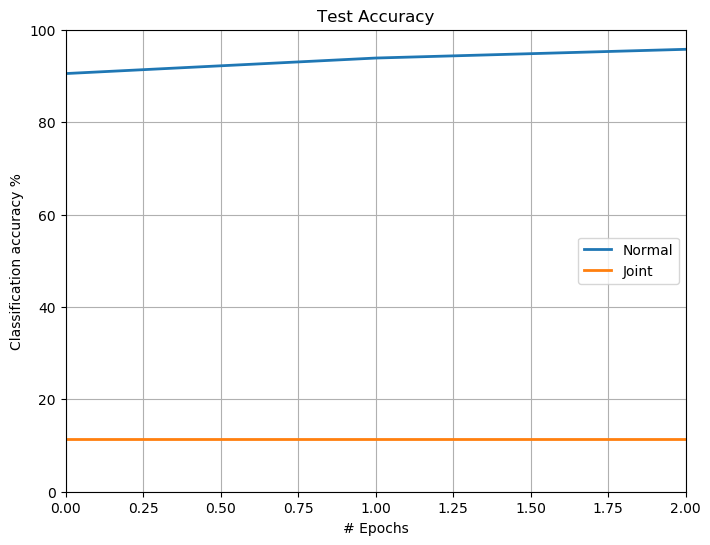

In [45]:
fig = plt.figure(figsize=(8,6))
plt.style.use('default')
plt.plot(Acc_test_nn, linewidth = 2,label='Normal')
plt.plot(Acc_test_jnn, linewidth = 2,label = 'Joint')
plt.grid('on')
plt.title('Test Accuracy')

plt.ylabel('Classification accuracy %')
plt.xlabel('# Epochs')
plt.legend()
plt.axis([0, EPOCH-1, 0, 100])
plt.show()

## Histrograms of activations

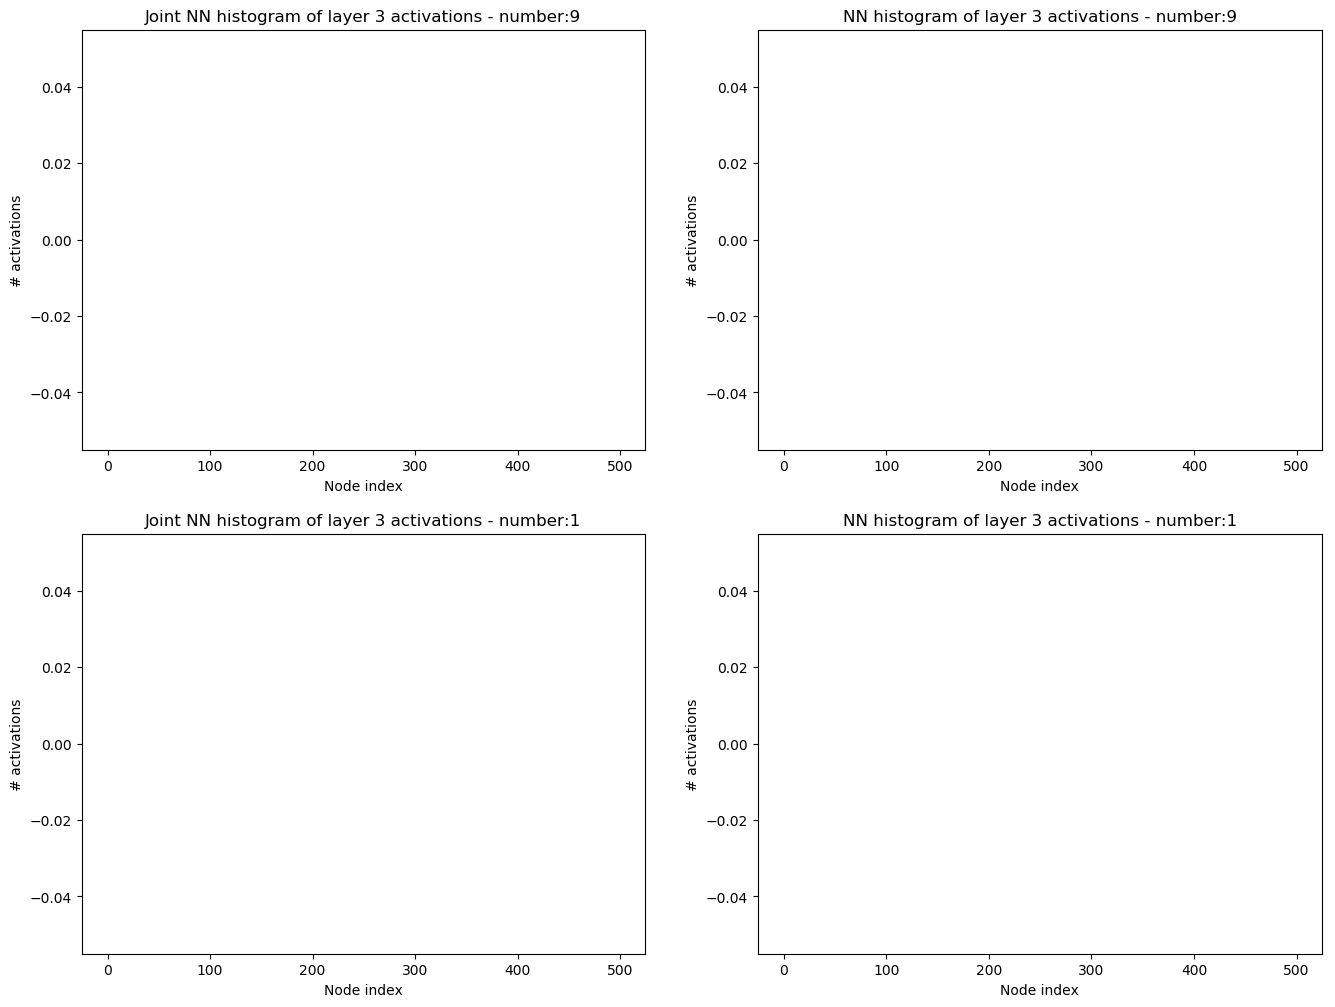

In [8]:
idx1 = 9
idx2 = 1

plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
plt.bar(np.arange(m3), activations_count3_jnn[str(idx1)])
plt.title('Joint NN histogram of layer 3 activations - number:' + str(idx1))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.subplot(2,2,2)
plt.bar(np.arange(m3), activations_count3_nn[str(idx1)])
plt.title('NN histogram of layer 3 activations - number:' + str(idx1))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.subplot(2,2,3)
plt.bar(np.arange(m3), activations_count3_jnn[str(idx2)])
plt.title('Joint NN histogram of layer 3 activations - number:' + str(idx2))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.subplot(2,2,4)
plt.bar(np.arange(m3), activations_count3_nn[str(idx2)])
plt.title('NN histogram of layer 3 activations - number:' + str(idx2))
plt.xlabel('Node index')
plt.ylabel('# activations')
plt.show()

## Alternative visualisations of activations